🔍 Features most correlated with Germany/Luxembourg [€/MWh] Original resolutions_Day-ahead_prices_202301010000_202503050000_Hour:
 Germany/Luxembourg [€/MWh] Original resolutions_Day-ahead_prices_202301010000_202503050000_Hour    1.000000
Residual load [MWh] Original resolutions_Actual_consumption_Quarterhour                            0.817223
Lignite [MWh] Original resolutions_Actual_generation_Quarterhour                                   0.677028
Fossil gas [MWh] Original resolutions_Actual_generation_Quarterhour                                0.653380
Hard coal [MWh] Original resolutions_Actual_generation_Quarterhour                                 0.564457
Biomass [MWh] Original resolutions_Actual_generation_Quarterhour                                   0.513503
Hydro pumped storage [MWh] Original resolutions_Actual_generation_Quarterhour                      0.483714
Luxembourg (export) [MWh] Original resolutions_Cross-border_physical_flows_Quarterhour             0.476351
Total 

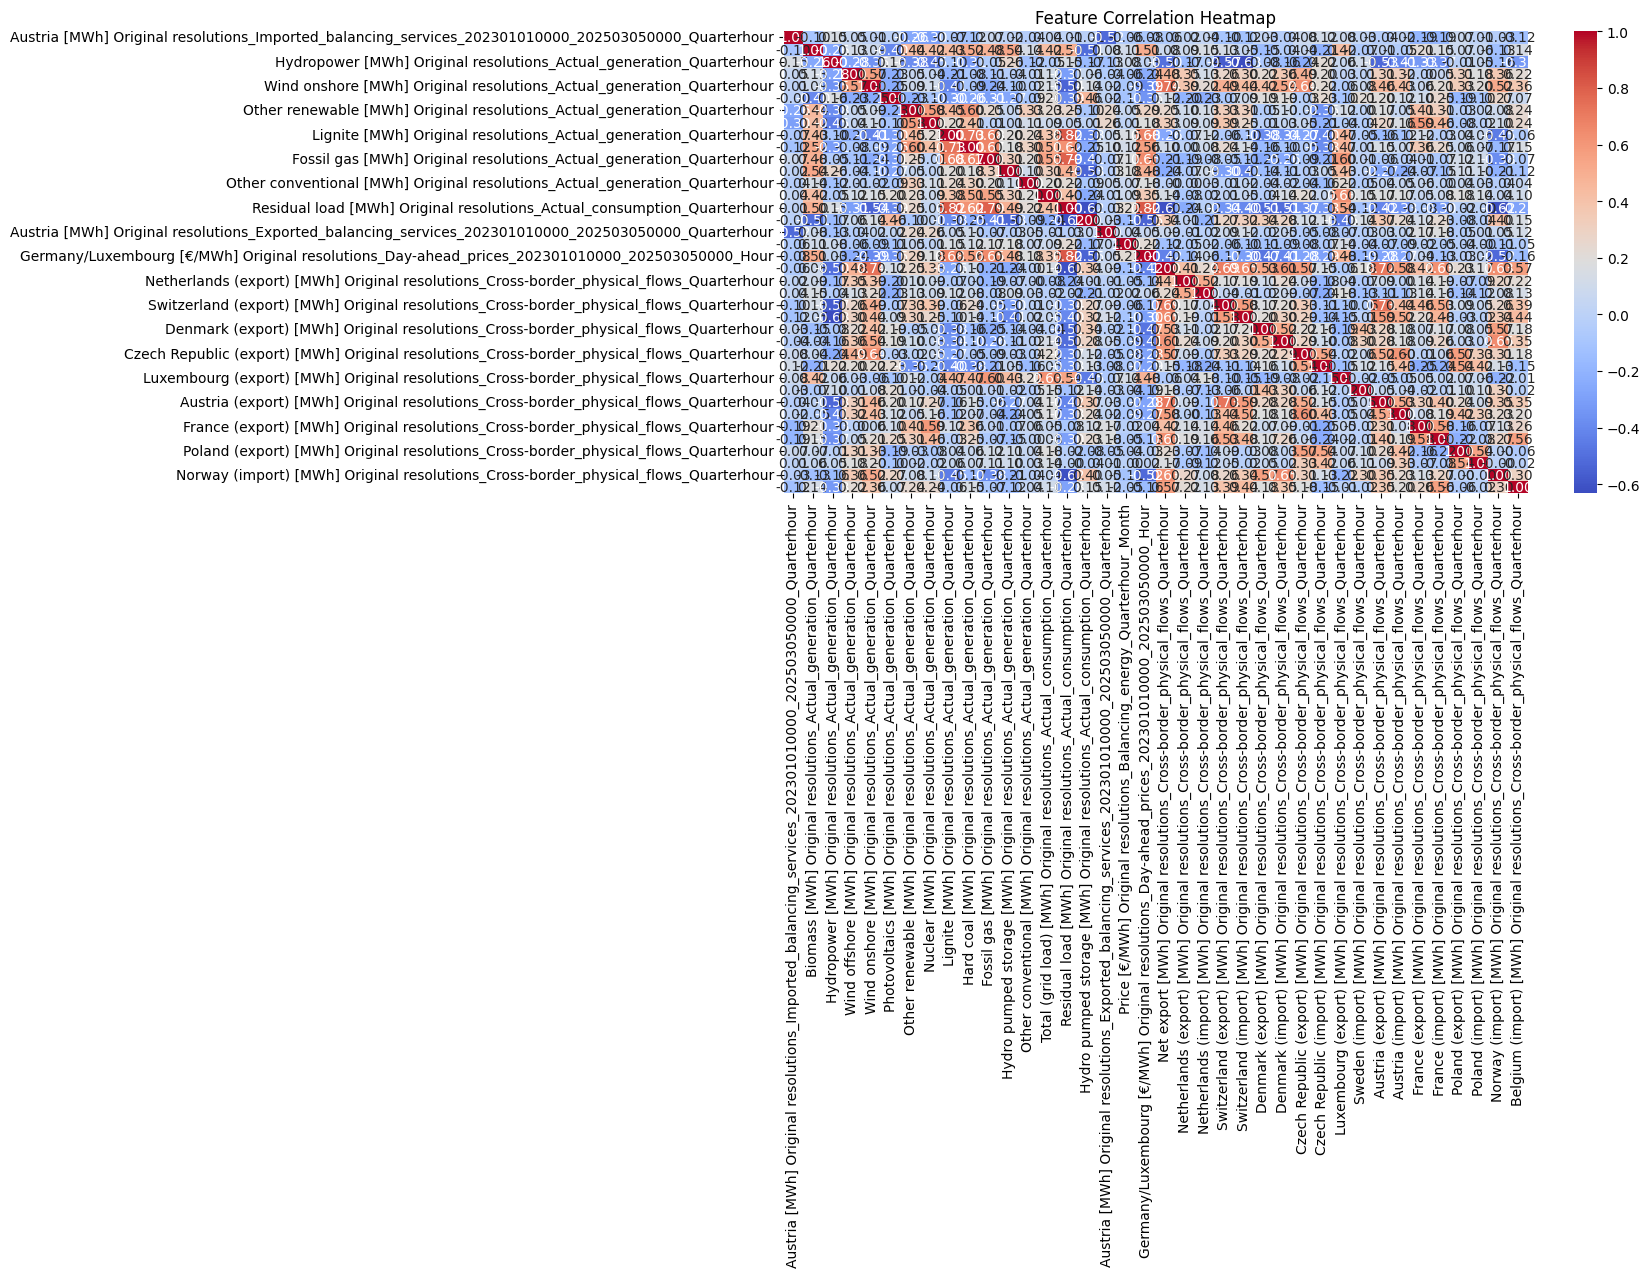

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

merged_df = pd.read_csv("./cleaned_and_merged.csv", delimiter =",", low_memory=False)
# Compute correlation
merged_df.drop(columns="Start date", inplace=True)


corr_matrix = merged_df.corr()

# Focus on correlations with price
target_col = "Germany/Luxembourg [€/MWh] Original resolutions_Day-ahead_prices_202301010000_202503050000_Hour"
corr_with_price = corr_matrix[target_col].sort_values(ascending=False)

print(f"Features most correlated with {target_col}:\n", corr_with_price.head(10))

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


XGBoost MAE: 27.38 €/MWh
107.84702842208429


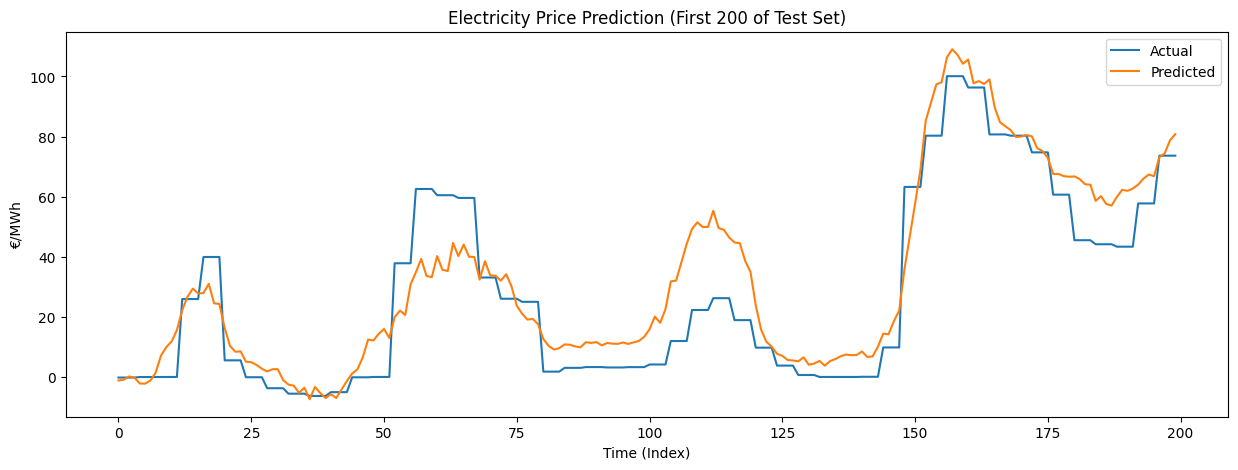

/var/folders/l7/36f7d7f518gg1x_4jx9flr380000gn/T/ipykernel_9237/2894441149.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")


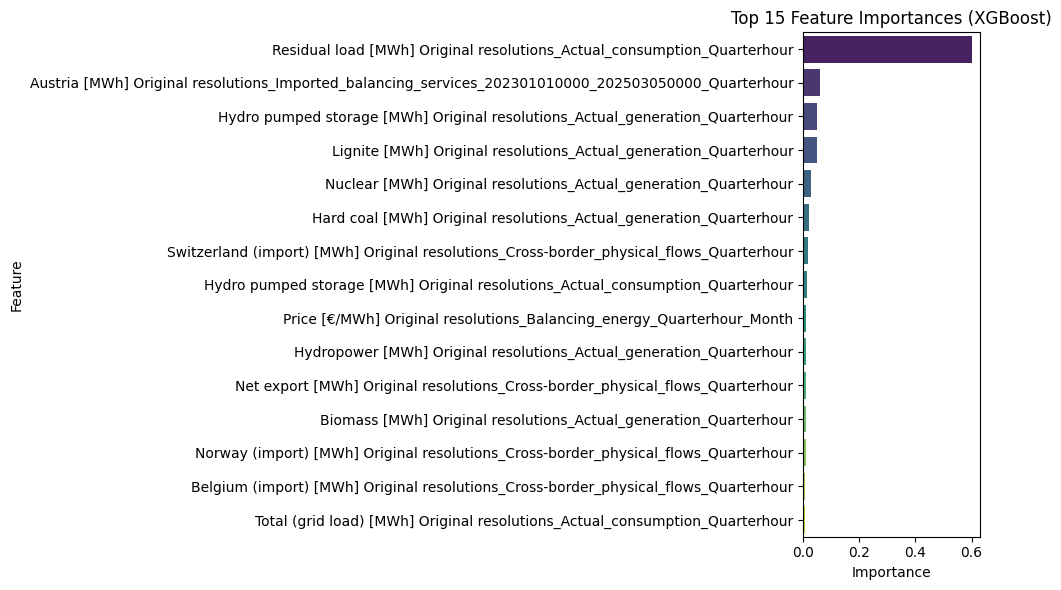

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Load and prep
merged_df = pd.read_csv("./cleaned_and_merged.csv", delimiter=",", low_memory=False)
merged_df.drop(columns="Start date", inplace=True)

target_col = "Germany/Luxembourg [€/MWh] Original resolutions_Day-ahead_prices_202301010000_202503050000_Hour"
X = merged_df.drop(columns=[target_col])
y = merged_df[target_col]

# Time-based 80/20 split
split_index = int(len(merged_df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Clean feature column names to remove brackets and other weird characters
X_train.columns = X_train.columns.str.replace(r"[\[\]<>]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[\[\]<>]", "", regex=True)

# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"XGBoost MAE: {mae:.2f} €/MWh")
print(y_test.mean())

# Plot predictions vs actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(preds[:200], label="Predicted")
plt.legend()
plt.title("Electricity Price Prediction (First 200 of Test Set)")
plt.ylabel("€/MWh")
plt.xlabel("Time (Index)")
plt.show()

# Plot feature importance
feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/var/folders/l7/36f7d7f518gg1x_4jx9flr380000gn/T/ipykernel_9237/1259321566.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")


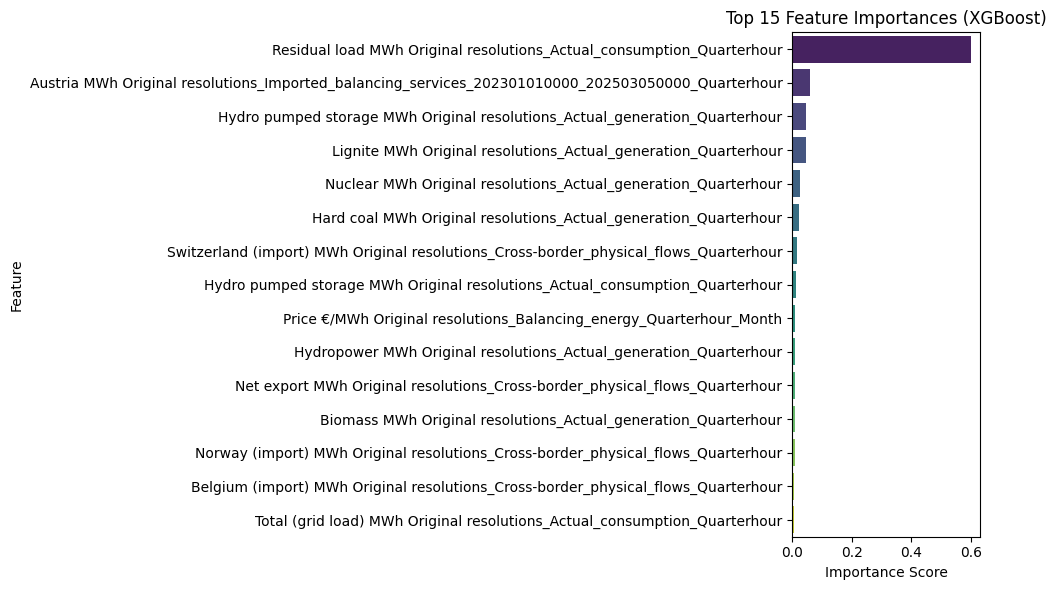

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained XGBoost model
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False).head(15)

# Plot the top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

# 💾 Save the plot as a PNG file
plt.savefig("feature_importance.png", dpi=300)
plt.show()


In [5]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Try only 10 random combos
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best Params:", random_search.best_params_)
print("Best MAE:", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'subsample': 1, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best MAE: 16.390884245830257


training model  Linear Regression
training model  XGBoost
training model  XGBoostOptimized
XGBoost: MAE = €27.38
XGBoostOptimized: MAE = €27.91
Linear Regression: MAE = €28.88


/var/folders/l7/36f7d7f518gg1x_4jx9flr380000gn/T/ipykernel_9237/386580132.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")


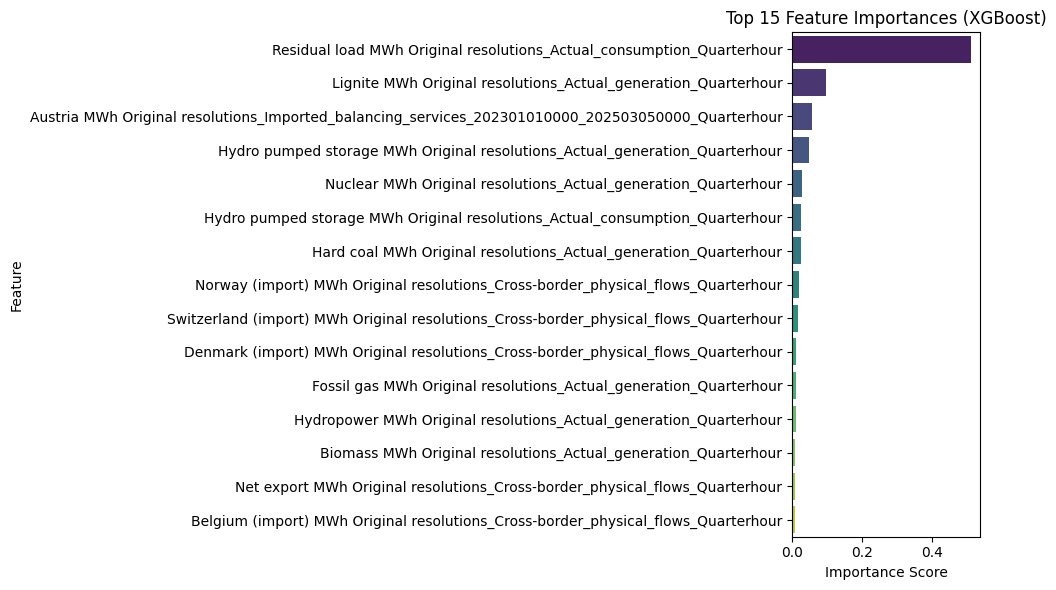

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
models = {
    "Linear Regression": LinearRegression(),
    #"Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    #"SVR": SVR(kernel='rbf'),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42),
    "XGBoostOptimized": xgb.XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05, random_state=44, colsample_bytree=0.8)
}

results = {}

for name, model in models.items():
    print("training model ", name)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae

# Print sorted results
for name, mae in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: MAE = €{mae:.2f}")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained XGBoost model
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False).head(15)

# Plot the top 15 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y="Feature", x="Importance", palette="viridis")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

# 💾 Save the plot as a PNG file
plt.savefig("feature_importance.png", dpi=300)
plt.show()